In [239]:
import numpy as np
from itertools import accumulate
from random import random
from matplotlib import pyplot as plt
from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [240]:
UNIVERSE_SIZE = 100
NUM_SETS = 10
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [241]:
# DON'T EDIT THESE LINES!
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [242]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution):
    return (valid(solution), -cost(solution))

## Have Fun!

In [243]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(284.22513760416325))

In [244]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.False_, np.float64(163.59636773967847))

In [245]:
# Tweaking functions
def tweak_single(solution: np.ndarray) -> np.ndarray:
    new_solution = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_solution[i] = not new_solution[i]
    return new_solution

def tweak_multiple(solution: np.ndarray) -> np.ndarray:
    mask = rng. random(NUM_SETS) < 0.01
    new_solution = np.logical_xor(solution, mask)
    return new_solution

'''
def tweak_multiple(solution, probability):
    new_solution = solution.copy()
    i = None
    while i is None or np.random.random() < probability:
        i = np.random.randint(0, NUM_SETS)
        new_solution[i] = not new_solution[i]
    return new_solution'''

def tweak_based_on_temperature(temperature: float, solution: np.ndarray) -> np.ndarray:
    if temperature > 0.7:
        # favors exploration, bigger jumps
        return tweak_multiple(solution, 0.8)
    elif temperature > 0.3:
        # tradeoff between exploration and exploitation
        return tweak_multiple(solution, 0.4)
    else:
        # favors exploitation, smaller jumps
        return tweak_single(solution)


In [246]:
def greedy_initialization():
    solution = np.zeros(NUM_SETS, dtype=bool)  
    uncovered_elements = set(range(UNIVERSE_SIZE)) 
    
    while uncovered_elements:
        best_set = None
        best_cover = 0
        for i in range(NUM_SETS):
            if not solution[i]:
                covered = np.sum(SETS[i, list(uncovered_elements)])
                if covered > best_cover:
                    best_cover = covered
                    best_set = i
        solution[best_set] = True
        uncovered_elements -= set(np.where(SETS[best_set])[0]) 
        
    return solution

In [247]:
test_solution = greedy_initialization()
ic(fitness(test_solution))

ic| fitness(test_solution): (np.True_, np.float64(-263.1130110317969))


(np.True_, np.float64(-263.1130110317969))

In [248]:
solution = rng.random(NUM_SETS) < 1
#solution = greedy_initialization()
solution_fitness = fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))

temperature = 0.8
cooling_rate = 0.95

for steps in range(1000):
    new_solution = tweak_based_on_temperature(solution, temperature)
    new_fitness = fitness(new_solution)
    history.append(float(new_fitness[1]))
    ic(new_fitness)
        
    if new_fitness > solution_fitness:
        solution = new_solution
        solution_fitness = new_fitness
            
    else:
        acceptance_prob = np.exp(-((solution_fitness[1]) - (new_fitness[1])) / temperature)
        if np.random.rand() < acceptance_prob:
            solution = new_solution
            solution_fitness = new_fitness
                    
    temperature *= cooling_rate
        
ic(fitness(solution))

plt.figure(figsize=(14,8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

ic| fitness(solution): (np.True_, np.float64(-284.22513760416325))


TypeError: tweak_multiple() takes 1 positional argument but 2 were given

ic| fitness(solution): (

np.True_, np.float64(-288.23486174440154))
ic| fitness(solution): (np.False_, np.float64(-0.0))


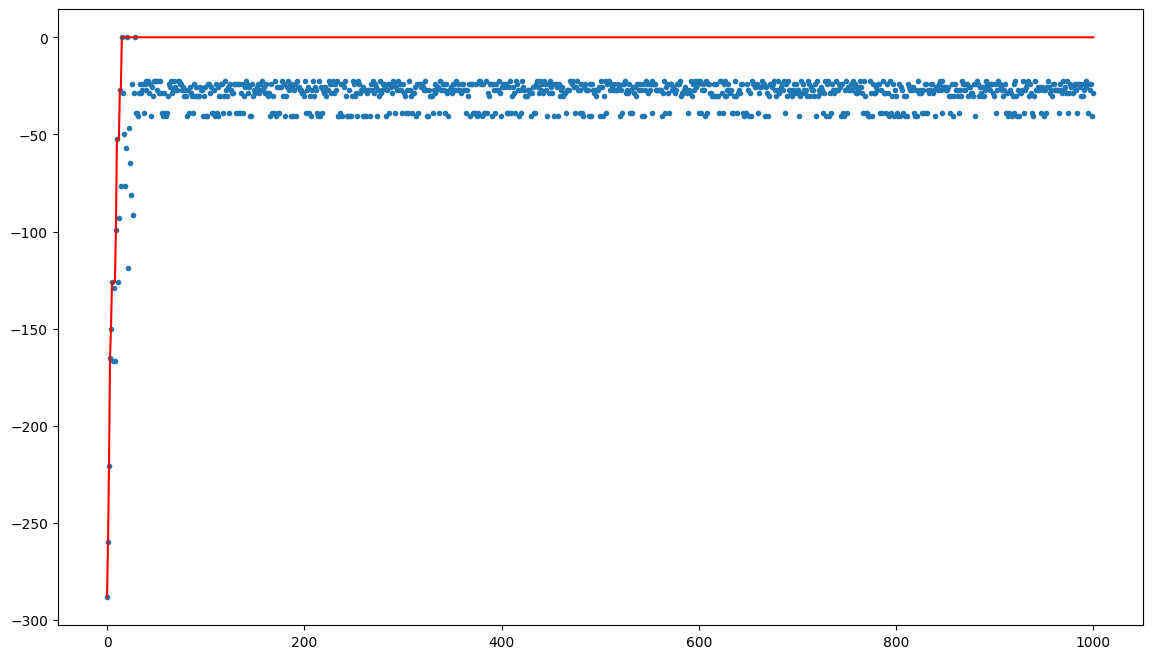

In [238]:
solution = rng.random(NUM_SETS) < 1
#solution = greedy_initialization()
solution_fitness = fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))

temperature = 0.8
cooling_rate = 0.95

for steps in range(1000):
    new_solution = tweak_based_on_temperature(solution, temperature)
    new_fitness = fitness(new_solution)
    history.append(float(new_fitness[1]))
        
    if new_fitness > solution_fitness:
        solution = new_solution
        solution_fitness = new_fitness
            
    else:
        acceptance_prob = np.exp(-((solution_fitness[1]) - (new_fitness[1])) / temperature)
        if np.random.rand() < acceptance_prob:
            solution = new_solution
            solution_fitness = new_fitness
        
        temperature *= cooling_rate
        
ic(fitness(solution))

plt.figure(figsize=(14,8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")